# Research on trading Regime models

The aim of this project is to infer Market states over time using 2 models : Gaussian Mixture Model & Hidden Markov Model

In [6]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import matplotlib.patches as patches
from matplotlib.lines import Line2D

from hmmlearn import hmm

### Data

In [7]:
path = r"/Users/thomascgd/Desktop/Data_Markets_Regimes.xlsx"
data = pd.read_excel(path, index_col='Date',parse_dates=True)
data.head()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
Date,,,,,,,
1989-01-03,497.22,92.19,86.1484,8.75,120.5,133.46,398.50
1989-01-04,497.10,93.07,85.9986,8.75,NaN,134.40,399.61
1989-01-05,496.54,93.67,86.4802,8.75,NaN,135.22,399.06
1989-01-06,494.58,94.47,86.7015,8.75,NaN,135.88,398.62
1989-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12779 entries, 1989-01-03 to 2023-12-29
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Equity            9129 non-null   float64
 1   FX                9052 non-null   float64
 2   Commodities       8786 non-null   float64
 3   Rates             8992 non-null   float64
 4   Inflation         420 non-null    float64
 5   Emerging Markets  9129 non-null   float64
 6   US Corporate IG   8760 non-null   float64
dtypes: float64(7)
memory usage: 798.7 KB


### Data Manipulation

In [9]:
data['Inflation'] = data['Inflation'].ffill() # Monthly Inflation Data published on the last sunday of the month
data['Inflation'] = data['Inflation'].pct_change() 
data['Inflation'] = data['Inflation'].replace(0,pd.NA)
data['Inflation'] = data['Inflation'].ffill()

data['US Corporate IG'] = data['US Corporate IG'].pct_change()

data.dropna(inplace=True) #Deleting the week ends that we have because of the inflation index. 
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8765 entries, 1989-01-31 to 2023-12-29
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Equity            8765 non-null   float64
 1   FX                8765 non-null   float64
 2   Commodities       8765 non-null   float64
 3   Rates             8765 non-null   float64
 4   Inflation         8765 non-null   float64
 5   Emerging Markets  8765 non-null   float64
 6   US Corporate IG   8765 non-null   float64
dtypes: float64(7)
memory usage: 547.8 KB


/var/folders/hv/96hzjq1n5hd2lms55ltz5n_00000gn/T/ipykernel_36954/4004111068.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['US Corporate IG'] = data['US Corporate IG'].pct_change()


### Data ploting

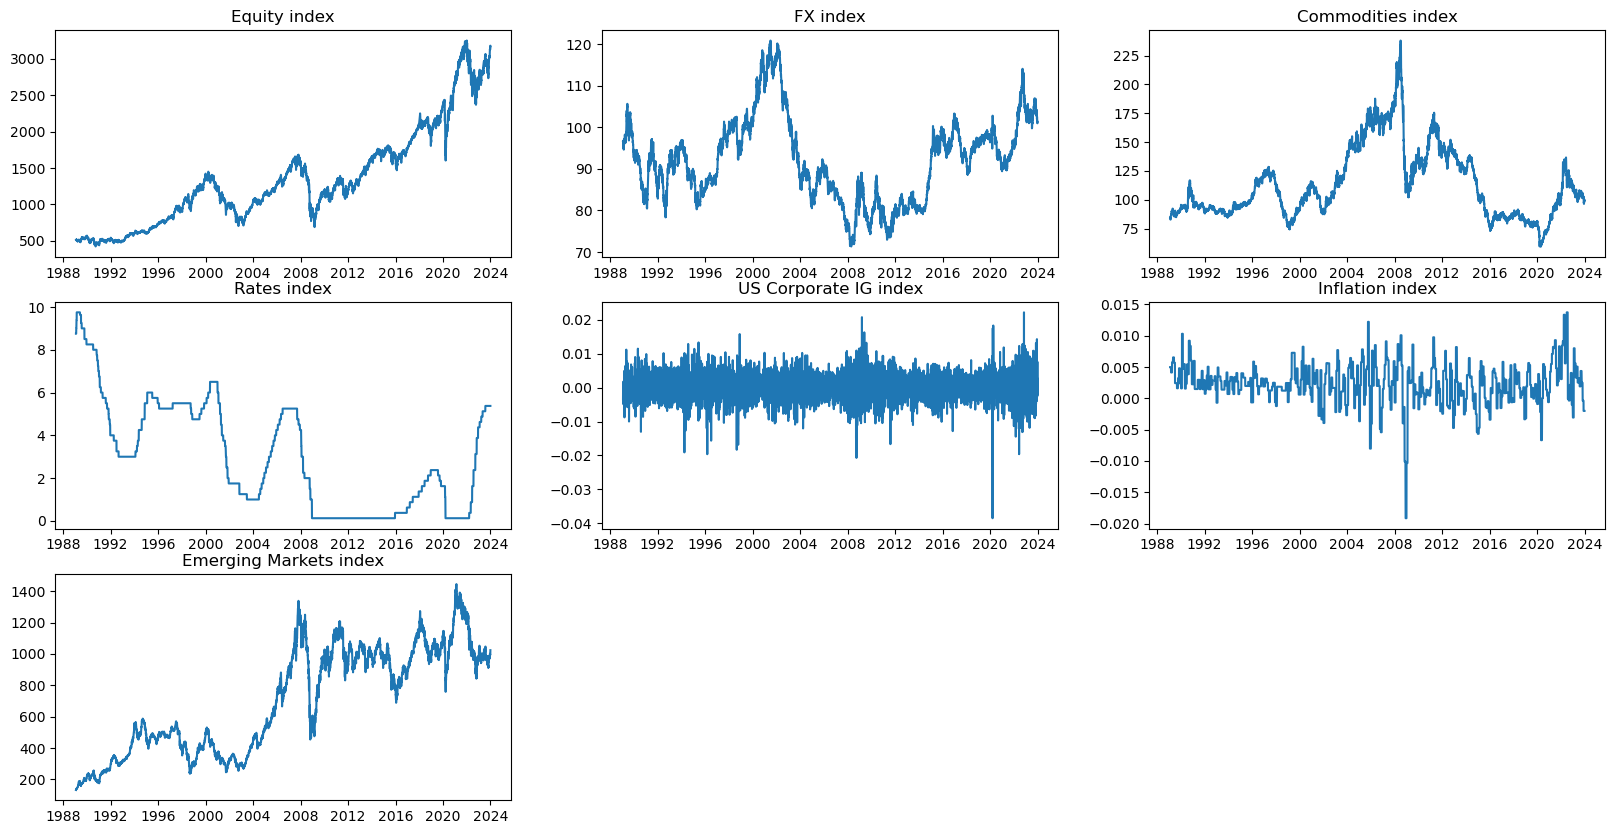

In [10]:
plt.figure(figsize=(20,10))

plt.subplot(3,3,1)
plt.plot(data["Equity"])
plt.title("Equity index")

plt.subplot(3,3,2)
plt.plot(data["FX"])
plt.title("FX index")

plt.subplot(3,3,3)
plt.plot(data["Commodities"])
plt.title("Commodities index")

plt.subplot(3,3,4)
plt.plot(data["Rates"])
plt.title("Rates index")

plt.subplot(3,3,5)
plt.plot(data["US Corporate IG"])
plt.title("US Corporate IG index")

plt.subplot(3,3,6)
plt.plot(data["Inflation"])
plt.title("Inflation index")

plt.subplot(3,3,7)
plt.plot(data["Emerging Markets"])
plt.title("Emerging Markets index")

plt.show()

### Data Standardization

In [11]:
data[['Equity','FX','Commodities','Emerging Markets']] = data[['Equity','FX','Commodities','Emerging Markets']].pct_change()
data[['Equity','FX','Commodities','Inflation','Emerging Markets','US Corporate IG']] * 100 # in %
data.dropna(inplace=True)
data.head()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
Date,,,,,,,
1989-02-01,-0.005103,0.000517,0.002603,8.75,0.004979,0.006935,0.000446
1989-02-02,0.001552,-0.000310,-0.001016,8.75,0.004979,0.011005,0.000396
1989-02-03,0.003551,-0.000310,-0.002427,8.75,0.004979,0.015402,0.000718
1989-02-06,-0.001369,-0.001757,-0.006463,8.75,0.004979,-0.000656,0.000000
1989-02-07,0.007204,0.000414,0.003644,8.75,0.004979,-0.000949,0.000495


In [12]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [13]:
df = pd.DataFrame(index=data.index,data=data_scaled,columns=['Equity','FX','Commodities','Rates','Inflation','Emerging Markets','US Corporate IG'])
df.head()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
Date,,,,,,,
1989-02-01,-0.558100,0.097866,0.271194,2.284742,0.78131,0.577911,0.059145
1989-02-02,0.135236,-0.064423,-0.114976,2.284742,0.78131,0.932342,0.044506
1989-02-03,0.343481,-0.064442,-0.265498,2.284742,0.78131,1.315291,0.139199
1989-02-06,-0.169075,-0.348550,-0.696024,2.284742,0.78131,-0.083233,-0.072142
1989-02-07,0.724087,0.077728,0.382236,2.284742,0.78131,-0.108692,0.073506


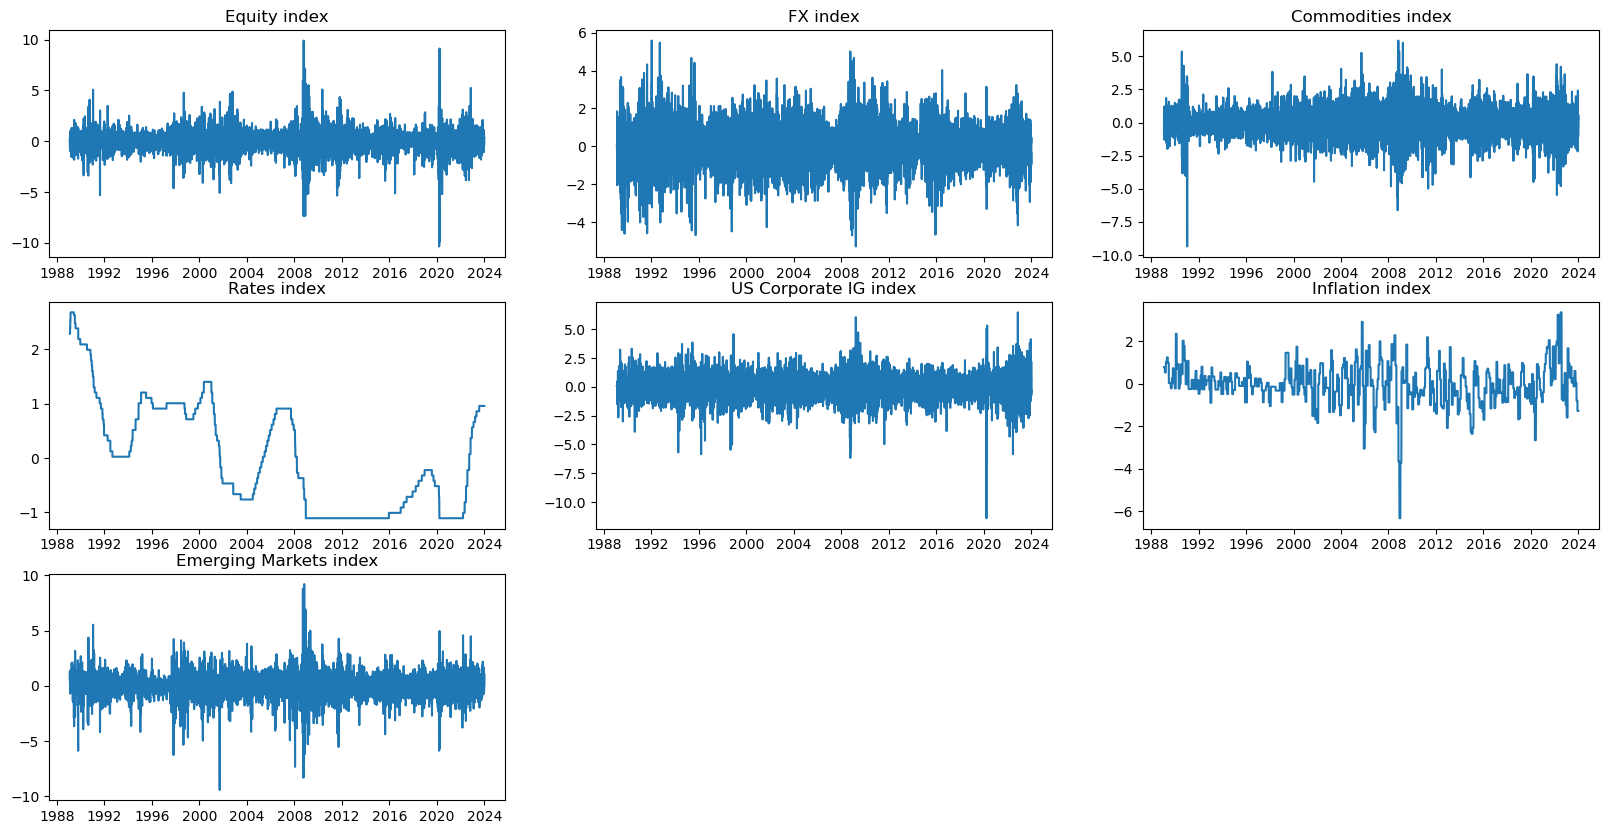

In [14]:
plt.figure(figsize=(20,10))

plt.subplot(3,3,1)
plt.plot(df["Equity"])
plt.title("Equity index")

plt.subplot(3,3,2)
plt.plot(df["FX"])
plt.title("FX index")

plt.subplot(3,3,3)
plt.plot(df["Commodities"])
plt.title("Commodities index")

plt.subplot(3,3,4)
plt.plot(df["Rates"])
plt.title("Rates index")

plt.subplot(3,3,5)
plt.plot(df["US Corporate IG"])
plt.title("US Corporate IG index")

plt.subplot(3,3,6)
plt.plot(df["Inflation"])
plt.title("Inflation index")

plt.subplot(3,3,7)
plt.plot(df["Emerging Markets"])
plt.title("Emerging Markets index")

plt.show()

### Correlation Matrix

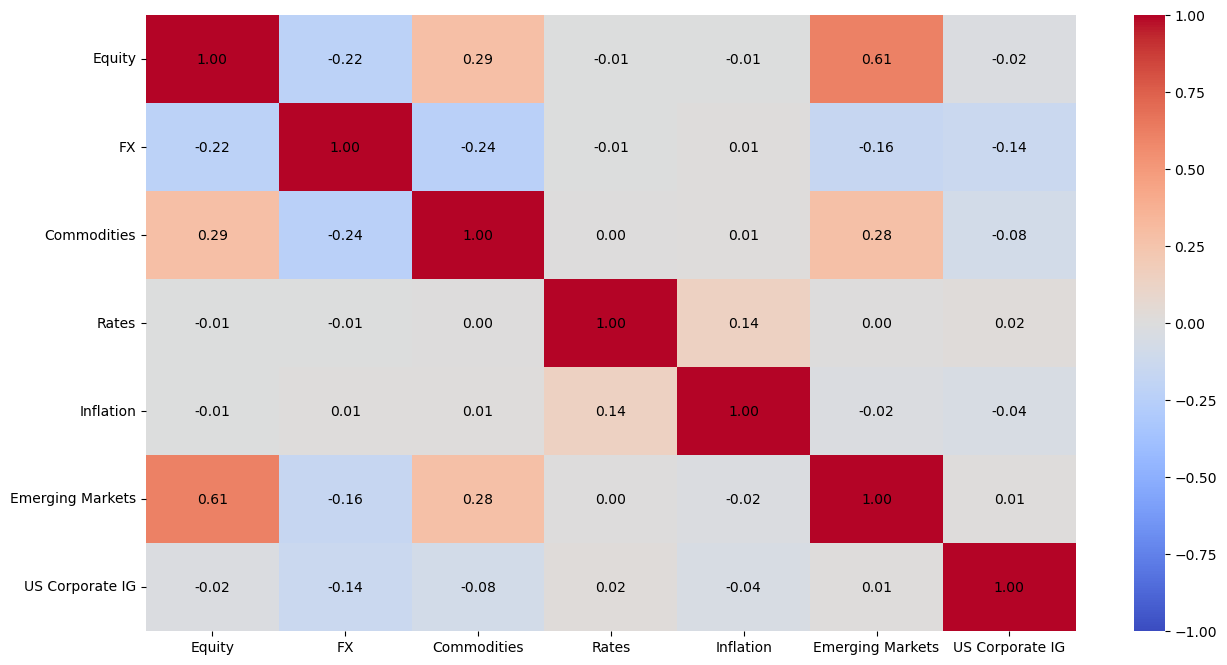

In [15]:
CorrMatrix = df.corr()

plt.figure(figsize=(15,8))
sns.heatmap(CorrMatrix,cmap='coolwarm',center=0,vmax=1,vmin=-1,fmt='.2f')

for i in range(len(CorrMatrix)):
    for j in range(len(CorrMatrix)):
        plt.text(j + 0.5, i + 0.5, f'{CorrMatrix.iloc[i, j]:.2f}', ha='center', va='center', fontsize=10)

plt.show()

### AIC & BIC scores - GMM

AIC : best number of market regimes : 14
BIC : best number of market regimes : 10


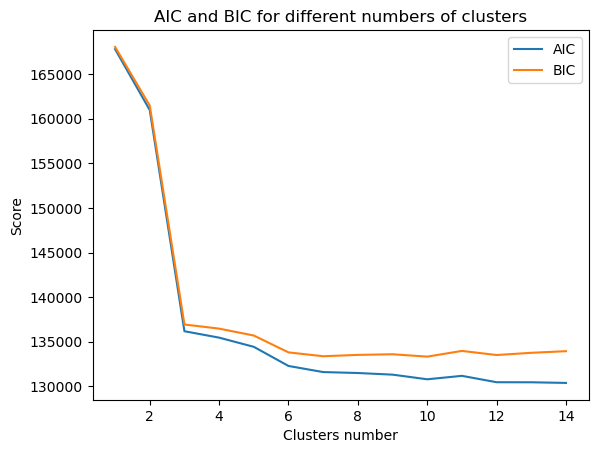

In [16]:
n_market_regimes = range(1, 15)
aic_scores = []
bic_scores = []

for market_regime in n_market_regimes:
    gmm = GaussianMixture(n_components=market_regime, random_state=42, init_params='kmeans')
    gmm.fit(df)
    aic_scores.append(gmm.aic(df))
    bic_scores.append(gmm.bic(df))

print(f"AIC : best number of market regimes : {aic_scores.index(min(aic_scores))+1}")
print(f"BIC : best number of market regimes : {bic_scores.index(min(bic_scores))+1}")

plt.plot(n_market_regimes, aic_scores, label='AIC')
plt.plot(n_market_regimes, bic_scores, label='BIC')
plt.xlabel('Clusters number')
plt.ylabel('Score')
plt.legend()
plt.title('AIC and BIC for different numbers of clusters')
plt.show()

### Gaussian Mixtures Model - GMM

In [17]:
market_regimes = 6
gmm = GaussianMixture(n_components=market_regimes)
gmm.fit(df)
clusters = gmm.predict(df)

/var/folders/hv/96hzjq1n5hd2lms55ltz5n_00000gn/T/ipykernel_36954/4037460916.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_list = plt.cm.get_cmap('tab20',market_regimes)


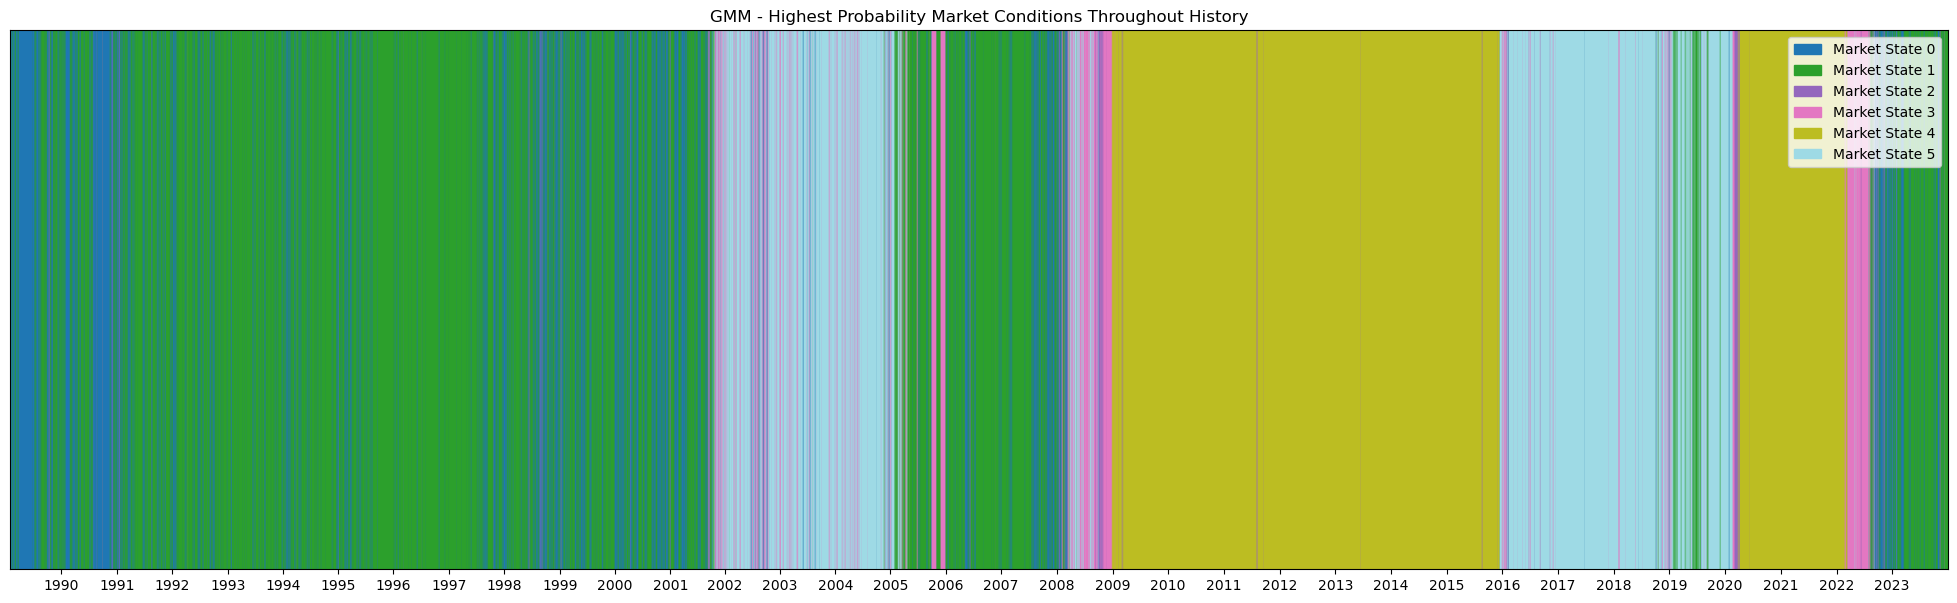

In [18]:
# Couleurs pour chaque régime de marché
colors_list = plt.cm.get_cmap('tab20',market_regimes)

# Création d'une figure pour la frise
fig, ax = plt.subplots(figsize=(25, 7))

# Hauteur du rectangle pour la frise
rectangle_height = 1

# Tracé des rectangles pour chaque date
for i, date in enumerate(data.index):
    color = colors_list(clusters[i])

    # Création du rectangle
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

# Configuration de l'axe des x pour afficher uniquement les années
years = [date.year for date in data.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

# Configuration des limites de l'axe
ax.set_xlim(0, len(data))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([])  # Pas de marques sur l'axe des y

# Création d'une légende pour les états de marché
legend_elements = [
    patches.Patch(color=colors_list(i), label=f'Market State {i}')
    for i in range(market_regimes)
]
ax.legend(handles=legend_elements, loc='upper right')

# Titre et affichage du graphique
ax.set_title('GMM - Highest Probability Market Conditions Throughout History')
plt.show()

#### Characteristics of each market regimes

In [19]:
data['GMM_MarketRegime'] = clusters
data.head()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG,GMM_MarketRegime
Date,,,,,,,,
1989-02-01,-0.005103,0.000517,0.002603,8.75,0.004979,0.006935,0.000446,1
1989-02-02,0.001552,-0.000310,-0.001016,8.75,0.004979,0.011005,0.000396,1
1989-02-03,0.003551,-0.000310,-0.002427,8.75,0.004979,0.015402,0.000718,0
1989-02-06,-0.001369,-0.001757,-0.006463,8.75,0.004979,-0.000656,0.000000,1
1989-02-07,0.007204,0.000414,0.003644,8.75,0.004979,-0.000949,0.000495,1


In [20]:
data.groupby('GMM_MarketRegime').count()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
GMM_MarketRegime,,,,,,,
0,1195,1195,1195,1195,1195,1195,1195
1,3075,3075,3075,3075,3075,3075,3075
2,112,112,112,112,112,112,112
3,516,516,516,516,516,516,516
4,2227,2227,2227,2227,2227,2227,2227
5,1639,1639,1639,1639,1639,1639,1639


In [21]:
for col in data.columns[:-1]:
    print(col)
    print(data.groupby('GMM_MarketRegime')[col].agg(['mean','min','max','std']))
    print('-'*30)

Equity
                      mean       min       max       std
GMM_MarketRegime                                        
0                -0.001033 -0.035854  0.032760  0.011265
1                 0.000807 -0.013972  0.017580  0.005026
2                -0.003529 -0.099151  0.095229  0.039416
3                -0.001770 -0.070106  0.054797  0.015836
4                 0.000583 -0.049290  0.050929  0.009642
5                 0.000605 -0.018746  0.023196  0.006181
------------------------------
FX
                      mean       min       max       std
GMM_MarketRegime                                        
0                -0.000235 -0.023848  0.028447  0.007507
1                 0.000156 -0.011421  0.012553  0.003825
2                -0.001667 -0.026894  0.025519  0.011551
3                 0.000621 -0.022000  0.023797  0.006804
4                 0.000091 -0.017929  0.018453  0.004771
5                -0.000228 -0.015064  0.012768  0.003914
------------------------------
Commodities
    

### AIC & BIC scores - HMM 

AIC : best number of market regimes : 11
BIC : best number of market regimes : 11


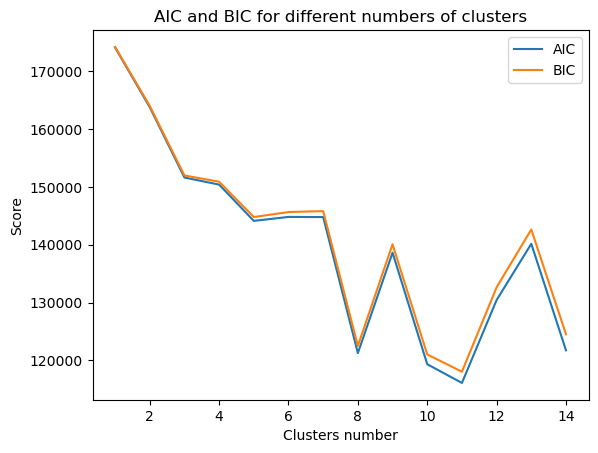

In [22]:
n_market_regimes = range(1, 15)
hmm_aic_scores = []
hmm_bic_scores = []

for market_regime in n_market_regimes:
    hm = hmm.GaussianHMM(n_components=market_regime, covariance_type='diag')
    hm.fit(df)
    hmm_aic_scores.append(hm.aic(df))
    hmm_bic_scores.append(hm.bic(df))

print(f"AIC : best number of market regimes : {hmm_aic_scores.index(min(hmm_aic_scores))+1}")
print(f"BIC : best number of market regimes : {hmm_bic_scores.index(min(hmm_bic_scores))+1}")

plt.plot(n_market_regimes, hmm_aic_scores, label='AIC')
plt.plot(n_market_regimes, hmm_bic_scores, label='BIC')
plt.xlabel('Clusters number')
plt.ylabel('Score')
plt.legend()
plt.title('AIC and BIC for different numbers of clusters')
plt.show()

### Hidden Markov Model - HMM

In [28]:
hmm_market_regimes = 7
hm = hmm.GaussianHMM(n_components=hmm_market_regimes, covariance_type='diag')
hm.fit(df)
hmm_clusters = hm.predict(df)

/var/folders/hv/96hzjq1n5hd2lms55ltz5n_00000gn/T/ipykernel_36954/1048450257.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_list = plt.cm.get_cmap('tab20',hmm_market_regimes)


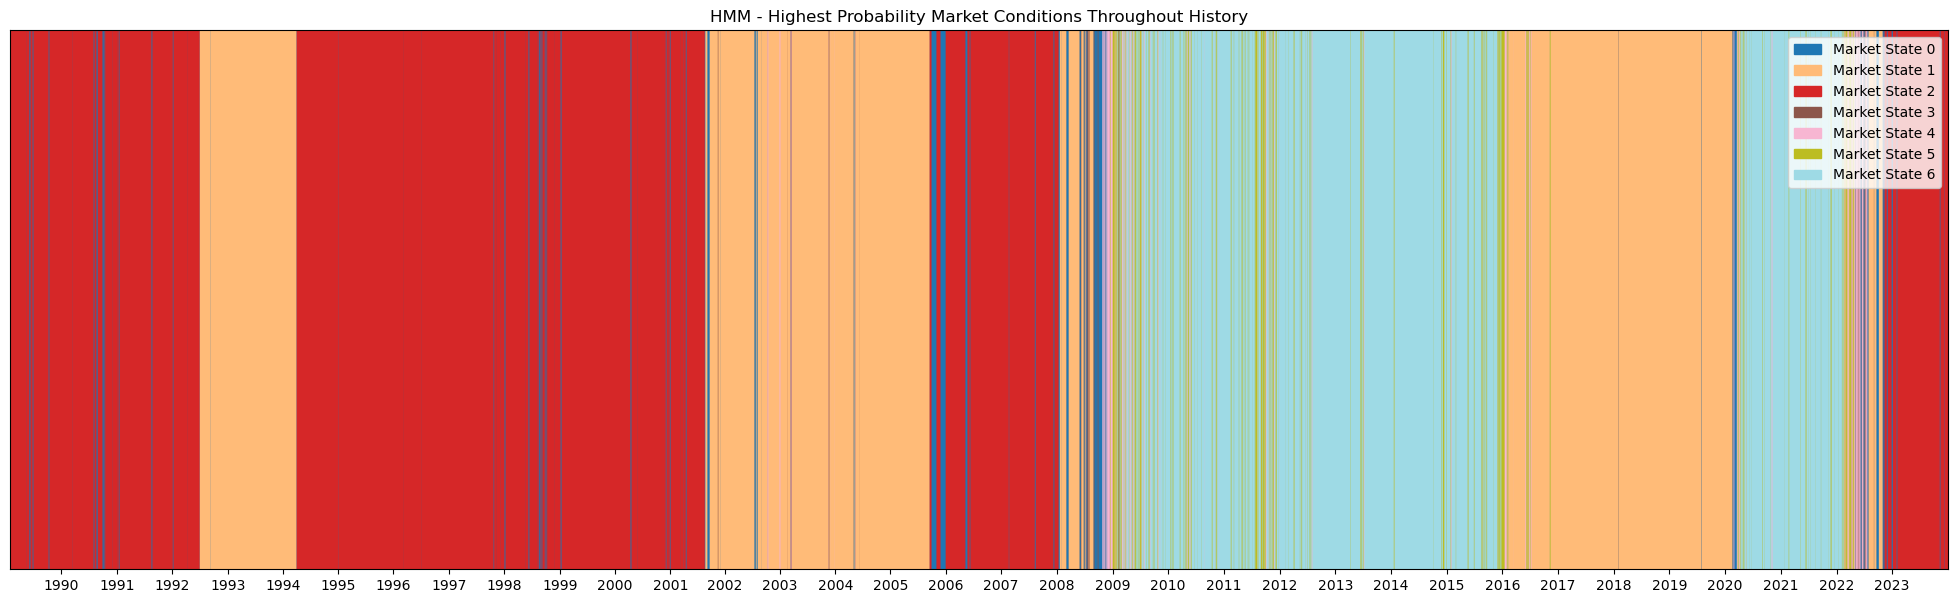

In [29]:
# Couleurs pour chaque régime de marché
colors_list = plt.cm.get_cmap('tab20',hmm_market_regimes)

# Création d'une figure pour la frise
fig, ax = plt.subplots(figsize=(25, 7))

# Hauteur du rectangle pour la frise
rectangle_height = 1

# Tracé des rectangles pour chaque date
for i, date in enumerate(data.index):
    color = colors_list(hmm_clusters[i])

    # Création du rectangle
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

# Configuration de l'axe des x pour afficher uniquement les années
years = [date.year for date in data.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

# Configuration des limites de l'axe
ax.set_xlim(0, len(data))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([])  # Pas de marques sur l'axe des y

# Création d'une légende pour les états de marché
legend_elements = [
    patches.Patch(color=colors_list(i), label=f'Market State {i}')
    for i in range(hmm_market_regimes)
]
ax.legend(handles=legend_elements, loc='upper right')

# Titre et affichage du graphique
ax.set_title('HMM - Highest Probability Market Conditions Throughout History')
plt.show()

#### Characteristics of each market regimes

In [30]:
data['HMM_MarketRegime'] = hmm_clusters
data.head()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG,GMM_MarketRegime,HMM_MarketRegime
Date,,,,,,,,,
1989-02-01,-0.005103,0.000517,0.002603,8.75,0.004979,0.006935,0.000446,1,2
1989-02-02,0.001552,-0.000310,-0.001016,8.75,0.004979,0.011005,0.000396,1,2
1989-02-03,0.003551,-0.000310,-0.002427,8.75,0.004979,0.015402,0.000718,0,2
1989-02-06,-0.001369,-0.001757,-0.006463,8.75,0.004979,-0.000656,0.000000,1,2
1989-02-07,0.007204,0.000414,0.003644,8.75,0.004979,-0.000949,0.000495,1,2


In [31]:
data.groupby('HMM_MarketRegime').count()

,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG,GMM_MarketRegime
HMM_MarketRegime,,,,,,,,
0,319,319,319,319,319,319,319,319
1,2527,2527,2527,2527,2527,2527,2527,2527
2,3407,3407,3407,3407,3407,3407,3407,3407
3,65,65,65,65,65,65,65,65
4,218,218,218,218,218,218,218,218
5,325,325,325,325,325,325,325,325
6,1903,1903,1903,1903,1903,1903,1903,1903


In [32]:
for col in data.columns[:-2]:
    print(col)
    print(data.groupby('HMM_MarketRegime')[col].agg(['mean','min','max','std']))
    print('-'*30)

Equity
                      mean       min       max       std
HMM_MarketRegime                                        
0                -0.006508 -0.099151  0.095229  0.024365
1                 0.000324 -0.030731  0.027728  0.007080
2                 0.000433 -0.031995  0.032760  0.007133
3                -0.004603 -0.023413  0.025238  0.008395
4                 0.014663 -0.029765  0.087697  0.016298
5                -0.013050 -0.051204  0.028246  0.011665
6                 0.001762 -0.018542  0.027073  0.006845
------------------------------
FX
                      mean       min       max       std
HMM_MarketRegime                                        
0                 0.000634 -0.023361  0.028447  0.009139
1                -0.000094 -0.020438  0.019092  0.004695
2                -0.000003 -0.023848  0.023789  0.004826
3                 0.003124 -0.007201  0.017412  0.004461
4                -0.003948 -0.026894  0.012737  0.007224
5                 0.004159 -0.017641  0.023797 